Define and solve a linear Naghdi shell problem with a curved stress-free configuration given as analytical expression in terms of two curvilinear coordinates. We start with importing the required modules, setting matplotlib as plotting backend, and generically set the integration order to 4 to avoid the automatic setting of FEniCS which would lead to unreasonably high integration orders for complex forms.

In [1]:
%matplotlib inline

import os, sys

import numpy as np
import matplotlib.pyplot as plt

from dolfin import *
from mshr import *
from ufl import Index

from mpl_toolkits.mplot3d import Axes3D

parameters["form_compiler"]["quadrature_degree"] = 4
output_dir = "output/"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

An hyperbolic paraboloid shell made of a linear elastic isotropic homogeneous material with Young modulus $E$ and Poisson ratio $\nu$ is considered.
`G` and `lb` denote the shear modulus $G=E/(2(1+\nu))$ and the Lamé constant $\lambda=2G\nu/(1−2\nu)$. The (uniform) shell thickness is denoted by $t$.

In [2]:
E, nu = 2.0e8, 0.3
G = E/(2.0*(1.0 + nu))
lb = 2.0*G*nu/(1.0 - 2.0*nu)
t = Constant(1E-2)

The midplane of the initial (stress-free) configuration $\mathcal{S}_I$
 of the shell is given in the form of an analytical expression
$$y_I:x\in\mathcal{M}\subset R^2\to y_I(x)\in\mathcal{S}_I\subset \mathcal R^3 \qquad \mathcal{S}_I = \{x_1, x_2, x_1^2-x_2^2\}$$

in terms of the curvilinear coordinates $x$. Hence, we mesh the two-dimensional domain
$\mathcal{M}\equiv [-L/2,L/2]\times [-L/2,L/2]$

In [3]:
L = 1.0
P1, P2 = Point(-L/2, -L/2), Point(L/2, L/2)
ndiv = 40
mesh = RectangleMesh(P1, P2, ndiv, ndiv)

We provide the analytical expression of the initial shape as an `Expression` that we represent on a suitable `FunctionSpace` (here $P_2$, but other are choices are possible):

In [4]:
initial_shape = Expression(('x[0]','x[1]','x[0]*x[0] - x[1]*x[1]'), degree = 4)
V_y = FunctionSpace(mesh, VectorElement("P", triangle, degree=2, dim=3))
yI = project(initial_shape, V_y)

We compute the covariant and contravariant component of the metric tensor, `aI`, `aI_contra`; the covariant base vectors `g0`, `g1`; the contravariant base vectors `g0_c`, `g1_c`.

In [5]:
aI = grad(yI).T*grad(yI)
aI_contra, jI = inv(aI), det(aI)
g0, g1 = yI.dx(0), yI.dx(1)
g0_c, g1_c = aI_contra[0,0]*g0 + aI_contra[0,1]*g1, aI_contra[1,0]*g0 + aI_contra[1,1]*g1

Given the midplane, we define the corresponding unit normal as below and project on a suitable function space (here $P_1$
 but other choices are possible):

In [6]:
def normal(y):
    n = cross(y.dx(0), y.dx(1))
    return n/sqrt(inner(n,n))

V_normal = FunctionSpace(mesh, VectorElement("P", triangle, degree = 1, dim = 3))
nI = project(normal(yI), V_normal)

We can visualize the shell shape and its normal with this utility function

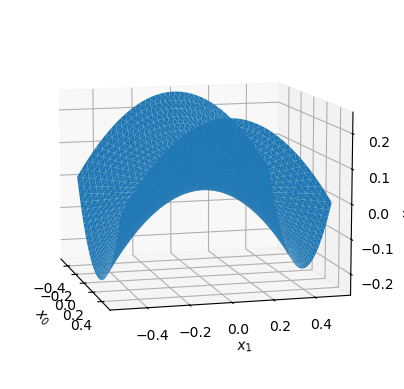

In [7]:
def plot_shell(y,n=None):
    y_0, y_1, y_2 = y.split(deepcopy=True)
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.plot_trisurf(y_0.compute_vertex_values(),
                    y_1.compute_vertex_values(),
                    y_2.compute_vertex_values(),
                    triangles=y.function_space().mesh().cells(),
                    linewidth=1, antialiased=True, shade = False)
    if n:
        n_0, n_1, n_2 = n.split(deepcopy=True)
        ax.quiver(y_0.compute_vertex_values(),
              y_1.compute_vertex_values(),
              y_2.compute_vertex_values(),
              n_0.compute_vertex_values(),
              n_1.compute_vertex_values(),
              n_2.compute_vertex_values(),
              length = .2, color = "r")
    ax.view_init(elev=10, azim=-15)
    # ax.set_xlim(-0.5, 0.5)
    # ax.set_ylim(-0.5, 0.5)
    # ax.set_zlim(-0.5, 0.5)
    ax.set_xlabel(r"$x_0$")
    ax.set_ylabel(r"$x_1$")
    ax.set_zlabel(r"$x_2$")
    return ax

plot_shell(yI)
plt.show()

In our 5-parameter Naghdi shell model the configuration of the shell is assigned by

the 3-component vector field `u_` representing the (small) displacement with respect to the initial configuration `yI`
the 2-component vector field `theta_` representing the (small) rotation of fibers orthogonal to the middle surface.
Following [2, 3], we use a `P2+bubble` element for `y_` and a `P2` element for `theta_`, and collect them in the state vector `z_=[u_, theta_]`. We further define `Function`, `TestFunction`, and `TrialFunction` and their different split views, which are useful for expressing the variational formulation.

In [8]:
P2 = FiniteElement("P", triangle, degree = 2)
bubble = FiniteElement("B", triangle, degree = 3)
enriched = P2 + bubble

# element = MixedElement([VectorElement(enriched, dim=3), VectorElement(P2, dim=2)])
# Z = FunctionSpace(mesh, element)

Z = FunctionSpace(mesh, MixedElement(3*[P2 + bubble ] + 2*[P2]))
z_ = Function(Z)
z, zt = TrialFunction(Z), TestFunction(Z)

u0_, u1_, u2_, th0_, th1_ = split(z_)
u0t, u1t, u2t, th0t, th1t = split(zt)
u0, u1, u2, th0, th1 = split(z)

We define the displacement vector and the rotation vector, with this latter tangent to the middle surface, $\theta=\theta_\sigma g^\sigma$, $\sigma=0,1$

In [35]:
u_, u, ut = as_vector([u0_, u1_, u2_]), as_vector([u0, u1, u2]), as_vector([u0t, u1t, u2t])
theta_, theta, thetat = th0_*g0_c + th1_*g1_c, th0*g0_c + th1*g1_c, th0t*g0_c + th1t*g1_c

The extensional, `e_naghdi`, bending, `k_naghdi`, and shearing, `g_naghdi`, strains in the linear Naghdi model are defined by

In [36]:
e_naghdi = lambda v: 0.5*(grad(yI).T*grad(v) + grad(v).T*grad(yI))
k_naghdi = lambda v, t: -0.5*(grad(yI).T*grad(t) + grad(t).T*grad(yI)) - 0.5*(grad(nI).T*grad(v) + grad(v).T*grad(nI))
g_naghdi = lambda v, t: grad(yI).T*t + grad(v).T*nI

Using curvilinear coordinates, the constitutive equations are written in terms of the matrix `A_hooke` below, representing the contravariant components of the constitutive tensor for isotropic elasticity in plane stress, see e.g. [4]. We use the index notation offered by UFL to express operations between tensors

In [37]:
i, j, k, l = Index(), Index(), Index(), Index()
A_hooke = as_tensor((((2.0*lb*G)/(lb + 2.0*G))*aI_contra[i,j]*aI_contra[k,l] \
                     + 1.0*G*(aI_contra[i,k]*aI_contra[j,l] + aI_contra[i,l]*aI_contra[j,k])),[i,j,k,l])

The membrane stress and bending moment tensors, `N` and `M`, and shear stress vector, `T`, are

In [39]:
N = as_tensor((A_hooke[i,j,k,l]*e_naghdi(u_)[k,l]),[i, j])
M = as_tensor(((1./12.0)*A_hooke[i,j,k,l]*k_naghdi(u_, theta_)[k,l]),[i, j])
T = as_tensor((G*aI_contra[i,j]*g_naghdi(u_, theta_)[j]), [i])

The contributions to the elastic energy densities due to membrane, `psi_m`, bending, `psi_b`, and shear, `psi_s`, are

In [40]:
psi_m = .5*inner(N, e_naghdi(u_))
psi_b = .5*inner(M, k_naghdi(u_, theta_))
psi_s = .5*inner(T, g_naghdi(u_, theta_))

Shear and membrane locking are treated using the PSRI proposed by Arnold and Brezzi, see [2, 3]. In this approach, shear and membrane energies are splitted as a sum of two weighted contributions, one of which is computed with a reduced integration. Thus, shear and membrane energies have the form

$$(i=m,s) \qquad \alpha \int_\mathcal{M} \psi_i \, \sqrt{j_I} \mathrm{d}x + (\kappa - \alpha) \int_\mathcal{M} \psi_i \, \sqrt{j_I} \mathrm{d}x_h, \qquad \text{where} \, \kappa \propto t^{-2}$$

While [2, 3] suggest a 1-point reduced integration, we observed that this leads to spurious modes in the present case. We use then $2\times 2$-points Gauss integration for the portion $\kappa-\alpha$ of the energy, whilst the rest is integrated with a $4\times 4$ scheme. As suggested in [3], we adopt an optimized weighting factor $\alpha=1$

In [41]:
dx_h = dx(metadata={'quadrature_degree': 2})
alpha = 1.0
kappa = 1.0/t**2
shear_energy = alpha*psi_s*sqrt(jI)*dx + (kappa - alpha)*psi_s*sqrt(jI)*dx_h
membrane_energy = alpha*psi_m*sqrt(jI)*dx + (kappa - alpha)*psi_m*sqrt(jI)*dx_h
bending_energy =  psi_b*sqrt(jI)*dx

The elastic energy is

In [42]:
elastic_energy = (t**3)*(bending_energy + membrane_energy + shear_energy)

The shell is subjected to a constant vertical load whose external work is

In [43]:
body_force = 8.*t
f = Constant(body_force)
external_work = f*u2_*sqrt(jI)*dx

The shell is subjected to a constant vertical load. Thus, the external work is

In [44]:
Pi_total = elastic_energy - external_work
residual = derivative(Pi_total, z_, zt)
hessian = derivative(residual, z_, z)

The boundary conditions prescribe a full clamping on the $x_0=−L/2$ boundary, while the other sides are left free

In [45]:
left_boundary = lambda x, on_boundary: abs(x[0] + L/2) <= DOLFIN_EPS and on_boundary
clamp = DirichletBC(Z, project(Expression(("0.0", "0.0", "0.0", "0.0", "0.0"), degree = 1), Z), left_boundary)
bcs = [clamp]

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


We now solve the linear system of equations

In [46]:
output_dir = "output/"
A, b = assemble_system(hessian, residual, bcs=bcs)
solver = PETScLUSolver("mumps")
solver.solve(A, z_.vector(), b)
u0_h, u1_h, u2_h, th0_h, th1_h = z_.split(deepcopy=True)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


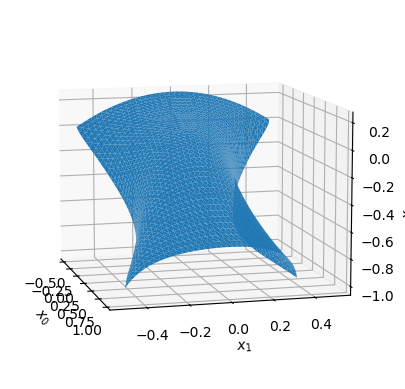

In [64]:
scale_factor = 1e4
plot_shell(project(scale_factor*u_ + yI, V_y))
# plt.show()
plt.savefig("output/finalconfiguration.png")

Finally, we can plot the final configuration of the shell

References

[1] K. J. Bathe, A. Iosilevich, and D. Chapelle. An evaluation of the MITC shell elements. Computers & Structures. 2000;75(1):1-30.

[2] D. Arnold and F.Brezzi, Mathematics of Computation, 66(217): 1-14, 1997. https://www.ima.umn.edu/~arnold//papers/shellelt.pdf

[3] D. Arnold and F.Brezzi, The partial selective reduced integration method and applications to shell problems. Computers & Structures. 64.1-4 (1997): 879-880.

[4] P. G. Ciarlet. An introduction to differential geometry with applications to elasticity. Journal of Elasticity, 78-79(1-3):1–215, 2005.